In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from tqdm import tqdm
import copy
from tqdm.auto import tqdm
import time
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def compute_A_infty(U_tilde, V_tilde):
    U_sym = 0.5 * (U_tilde + U_tilde.T) 
    eigvals, Q = np.linalg.eigh(U_sym)
    lam = np.clip(eigvals, 0.0, None)      
    Qt = Q.T
    invlam = np.zeros_like(lam)
    mask = lam > 1/ (p * 10000)
    invlam[mask] = 1.0 / lam[mask]
    U_pinv = (Q * invlam) @ Qt                      

    A_inf = V_tilde @ U_pinv               
    
    return A_inf

In [ ]:
import numpy as np

class RandomFeatureModel(nn.Module):
    def __init__(self, input_dim, feature_dim, K_t, T=1.0, activation='relu'):
        super().__init__()
        self.input_dim = input_dim  
        self.feature_dim = feature_dim  
        self.K_t = K_t
        self.T = T
        self.activation_name = activation
        self.A = nn.Parameter(torch.randn(input_dim, feature_dim))
        self.register_buffer('W_x', torch.randn(feature_dim, input_dim) / math.sqrt(input_dim))
        self.register_buffer('W_t', torch.randn(feature_dim, 2 * K_t + 1) / math.sqrt(2 * K_t + 1))
        self.register_buffer('b', torch.randn(feature_dim))
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            self.activation = F.relu  # Default to ReLU
            
    def time_parametrization(self, t):
        t_normalized = t / self.T
        batch_size = t.shape[0]
        phi = torch.zeros(batch_size, 2 * self.K_t + 1, device=t.device)
        phi[:, 0] = 1
        for k in range(1, self.K_t + 1):
            phi[:, 2*k-1] = torch.sin(2 * math.pi * k * t_normalized)
            phi[:, 2*k] = torch.cos(2 * math.pi * k * t_normalized)
            
        return phi
    
    def forward(self, x, t):
        batch_size = x.shape[0]
        phi = self.time_parametrization(t)  
        x_proj = torch.matmul(x, self.W_x.t())   
        t_proj = torch.matmul(phi, self.W_t.t()) 
        pre_activation = x_proj + t_proj + self.b.unsqueeze(0).expand(batch_size, -1)
        activated_features = self.activation(pre_activation)
        output = torch.matmul(activated_features, self.A.t()) / math.sqrt(self.feature_dim)
        
        return output
    
def evaluate_model_loss(model, data, z_grid, T=10.0, eps=1e-5, device='cuda',
                        t_grid_size=201, z_grid_size=700, t_batch_size=70):
    assert t_grid_size % 2 == 1, "t_grid_size must be odd for Simpson's rule"
    
    dtype = torch.float32
    model = model.to(device=device, dtype=dtype)
    data = data.to(device=device, dtype=dtype)
    z_grid = z_grid.to(device=device, dtype=dtype)
    t_grid = torch.linspace(eps, T, t_grid_size, device=device, dtype=dtype)
    
    simpson_avg_weights = torch.ones(t_grid_size, device=device, dtype=dtype)
    simpson_avg_weights[1:-1:2] = 4.0 
    simpson_avg_weights[2:-1:2] = 2.0 
    simpson_avg_weights /= (3.0 * (t_grid_size - 1))
    
    num_data = data.shape[0]
    data_dim = data.shape[1:]
    data_flat_size = 1
    if len(data_dim) > 0:
        data_flat_size = torch.prod(torch.tensor(data_dim)).item()
    
    x0 = data
    total_loss = 0.0
    t_start_index = 0 
    
    with torch.no_grad():
        for t_batch in torch.split(t_grid, t_batch_size):
            current_t_batch_size = t_batch.shape[0]
            
            x0_expanded = x0.repeat_interleave(current_t_batch_size * z_grid_size, dim=0)
            t_expanded = t_batch.repeat_interleave(z_grid_size).repeat(num_data)
            
            z_expanded = z_grid.repeat(num_data * current_t_batch_size, *([1] * len(data_dim)))
            
            exp_neg_t = torch.exp(-t_expanded)
            a_t = exp_neg_t
            sigma = torch.sqrt(1 - torch.exp(-2 * t_expanded))
            view_shape = (-1,) + (1,) * len(data_dim)
            xt = exp_neg_t.view(*view_shape) * x0_expanded + sigma.view(*view_shape) * z_expanded
            
            # 使用训练好的模型进行预测
            pred = model(xt, t_expanded)
            target = a_t.view(*view_shape) * x0_expanded
            squared_error = (pred - target) ** 2
            squared_error_view = squared_error.view(num_data, current_t_batch_size, z_grid_size, data_flat_size)

            loss_per_t = squared_error_view.mean(dim=(0, 2, 3)) 
            
            t_end_index = t_start_index + current_t_batch_size
            batch_weights = simpson_avg_weights[t_start_index:t_end_index]
            t_start_index = t_end_index 
            
            scaled_batch_loss = (loss_per_t * batch_weights).sum()
            total_loss += scaled_batch_loss.item() 
    
    return total_loss

def train_simpson(model, data, z_grid, epochs=40000, lr=0.001, T=10.0, eps=1e-5, device='cuda',
          t_grid_size=201, z_grid_size=700, t_batch_size=70, A_ref = None): 
    
    assert t_grid_size % 2 == 1, "t_grid_size must be odd for Simpson's rule"

    A_ref = A_ref.to(device=device) if A_ref is not None else None
    A_diff_history = []
    
    dtype = torch.float32
    model = model.to(device=device, dtype=dtype)
    data = data.to(device=device, dtype=dtype)
    z_grid = z_grid.to(device=device, dtype=dtype)
    
    t_grid = torch.linspace(eps, T, t_grid_size, device=device, dtype=dtype)
    
    simpson_avg_weights = torch.ones(t_grid_size, device=device, dtype=dtype)
    simpson_avg_weights[1:-1:2] = 4.0 
    simpson_avg_weights[2:-1:2] = 2.0 
    
    simpson_avg_weights /= (3.0 * (t_grid_size - 1))

    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_data = data.shape[0]
    data_dim = data.shape[1:]
    data_flat_size = 1
    if len(data_dim) > 0:
        data_flat_size = torch.prod(torch.tensor(data_dim)).item()


    loss_history = []
    
    x0 = data

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        
        epoch_total_loss = 0.0
        t_start_index = 0 

        for t_batch in torch.split(t_grid, t_batch_size):
            current_t_batch_size = t_batch.shape[0]
            
            x0_expanded = x0.repeat_interleave(current_t_batch_size * z_grid_size, dim=0)
            t_expanded = t_batch.repeat_interleave(z_grid_size).repeat(num_data)
            
            z_expanded = z_grid.repeat(num_data * current_t_batch_size, *([1] * len(data_dim)))
            
            exp_neg_t = torch.exp(-t_expanded)
            a_t = exp_neg_t
            sigma = torch.sqrt(1 - torch.exp(-2 * t_expanded))
            view_shape = (-1,) + (1,) * len(data_dim)
            xt = exp_neg_t.view(*view_shape) * x0_expanded + sigma.view(*view_shape) * z_expanded
            pred = model(xt, t_expanded)
            target = a_t.view(*view_shape) * x0_expanded
            squared_error = (pred - target) ** 2
            squared_error_view = squared_error.view(num_data, current_t_batch_size, z_grid_size, data_flat_size)

            loss_per_t = squared_error_view.mean(dim=(0, 2, 3)) 
            
            t_end_index = t_start_index + current_t_batch_size
            batch_weights = simpson_avg_weights[t_start_index:t_end_index]
            t_start_index = t_end_index 
            
            scaled_batch_loss = (loss_per_t * batch_weights).sum()

            scaled_batch_loss.backward()
            epoch_total_loss += scaled_batch_loss.item() 

        optimizer.step()

        if A_ref is not None:
            A_current = model.A
            diff = torch.norm(A_current - A_ref, p='fro').item()
            A_diff_history.append(diff)
        
        avg_epoch_loss = epoch_total_loss 
        loss_history.append(avg_epoch_loss)

    return loss_history, model, A_diff_history

def sample_exponential(model, num_samples=1000, dim=2, num_steps=10000, T=40.0, device='cuda',
                       num_snapshots=0):
    dtype = torch.float32
    model = model.to(device=device, dtype=dtype)
    g = math.sqrt(2.0)
    snapshots = []
    if num_snapshots > 0:
        snapshot_indices = torch.linspace(0, num_steps, num_snapshots, dtype=torch.int64)
        snapshot_indices_set = set(snapshot_indices.tolist())
    else:
        snapshot_indices_set = set()

    y = torch.randn(num_samples, dim, device=device, dtype=dtype)

    if 0 in snapshot_indices_set:
        snapshots.append(y.cpu().clone())
    
    t_min = 0.0001  # 仿真起始时间 (epsilon)
    t_max = T      # 仿真结束时间
    L_sde = num_steps # 步数

    # 1. 计算 q
    # (确保 t_min > 0, 否则 log(q) 会失败)
    if t_min <= 0:
        raise ValueError("t_min 必须大于 0 以进行指数调度。")
        
    q = (t_max / t_min) ** (1.0 / L_sde)

    time_points_np = np.array([t_min * (q ** i) for i in range(L_sde + 1)])
    
    time_points = torch.tensor(time_points_np, device=device, dtype=dtype)
    # --- END: 替换 ---

    with torch.no_grad():
        for i in range(num_steps):
            t_i = time_points[i]
            t_i_plus_1 = time_points[i+1]
            dt = t_i_plus_1 - t_i  
            
            # t_val 是当前时间 t_i
            t_val = torch.full((num_samples,), t_i, device=device, dtype=dtype)
            T_minus_t = T - t_val
            h_T_minus_t = 1 - torch.exp(-2 * T_minus_t)
            h_T_minus_t = h_T_minus_t.view(-1, 1)  
            
            h_T_minus_t = torch.clamp(h_T_minus_t, min=1e-9)
            
            model_output = model(y, T_minus_t)

            drift = y - (2 / h_T_minus_t) * y + (2 / h_T_minus_t) * model_output
            
            diffusion_term = g * math.sqrt(dt) * torch.randn_like(y)
            
            # 欧拉-丸山法更新
            y = y + drift * dt + diffusion_term
            
            # --- 快照逻辑 (不变) ---
            current_step = i + 1
            if current_step in snapshot_indices_set:
                snapshots.append(y.cpu().clone())
                
    if num_snapshots > 0:
        return snapshots
    else:
        # 返回在 T 时刻的最终采样结果
        return y

In [ ]:
data = torch.tensor([[1.0,0.0],[6.0, 0.0],[1.0, 5.0]], device=device)
data_repeated = data.repeat_interleave(2000, dim=0)
input_dim = 2
time_emb_dim = 128
T = 40.0
K_t = 64

data_sampling_mode = "centers"
m_z = 4000         
batch_size = 500 
ridge = 1e-9
bias_switch = 1

In [ ]:
p = 2048
d = input_dim
n = 3

def a_t(t: float) -> float:
    """Forward schedule function"""
    return np.exp(-t)

def h_t(t: float) -> float:
    """Variance schedule function"""
    return 1 - np.exp(- 2 * t)

def phi_time(t: float, K: int, T: float) -> np.ndarray:
    """Fourier time embedding of length 2K+1 at absolute time t in [0,T]."""
    tau = t / T
    ks = np.arange(1, K + 1)  # ks from 1 to K (not 0 to K-1)
    ang = 2.0 * math.pi * ks * tau
    # Include constant term (1) + sin/cos terms
    return np.concatenate([[1.0], np.sin(ang), np.cos(ang)], axis=0)  # (2K+1,)

def create_progress_bar(total, desc, start_time):
    return tqdm(
        total=total,
        desc=desc,
        unit="step",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
        ncols=100,
        leave=False,
        position=0,  # Always use position 0 for single line
        dynamic_ncols=True  # Adjust width dynamically
    )

def compute_UV_unweighted(X0, W_x, W_tau, b, ts, w, rng):
    n_data = n  
    at_values = np.array([a_t(t) for t in ts])  # (L_t+1,)
    ht_values = np.array([h_t(t) for t in ts])  # (L_t+1,)
    phi_vectors = np.array([phi_time(t, K_t, T) for t in ts])  # (L_t+1, 2K+1)
    Wphi_values = phi_vectors @ W_tau.T / math.sqrt(2 * K + 1)  # (L_t+1, p) with √K normalization

    pbar = create_progress_bar(len(ts), "UV computation", time.time())
    
    for i, (t, wt) in enumerate(zip(ts, w)):
        at, ht = at_values[i], ht_values[i]
        Wphi = Wphi_values[i]  # (p,)

        U_t_hat = np.zeros((p, p))
        V_t_hat = np.zeros((d, p))
        
        if data_sampling_mode == "centers":
        
            WX_X0T = W_x @ X0.T  # (p, n_data)
            
            m_z_batches = (m_z + batch_size - 1) // batch_size
            
            for m_batch_idx in range(m_z_batches):
                start_m = m_batch_idx * batch_size
                end_m = min((m_batch_idx + 1) * batch_size, m_z)
                m_batch_size = end_m - start_m
                
                Z_batch = rng.standard_normal((n_data, m_batch_size, d))  # (n_data, m_batch_size, d)
                WZ_over_sqrt_d_batch = np.einsum('pd,nmd->pnm', W_x, Z_batch) / math.sqrt(d)  # (p, n_data, m_batch_size)
                
                # mean term for all centers
                mean_i = WX_X0T * (at / math.sqrt(d + ridge))  # (p, n_data)
                # preactivations for this batch
                if bias_switch:
                    Z_all_batch = mean_i[:, :, None] + WZ_over_sqrt_d_batch + b[:, None, None] + Wphi[:, None, None]  # (p, n_data, m_batch_size)
                else:
                    Z_all_batch = mean_i[:, :, None] + WZ_over_sqrt_d_batch + Wphi[:, None, None]  # (p, n_data, m_batch_size)
                H_batch = np.maximum(0.0, Z_all_batch)  # (p, n_data, m_batch_size)
                
                # Accumulate U_t contribution from this batch
                H_flat_batch = H_batch.reshape(p, -1)  # (p, n_data * m_batch_size)
                U_t_hat += ht * (H_flat_batch @ H_flat_batch.T) / (n_data * m_z * p)
                
                # Accumulate V_t contribution from this batch
                # New formula: sqrt(ht) * (1/n_data) * sum_{i=1}^n_data * (1/mz) * sum_{m=1}^mz * z_m * sigma^T / p
                for i in range(n_data):
                    for m in range(m_batch_size):
                        z_m = Z_batch[i, m, :]  # (d,) - noise sample
                        sigma_m = H_batch[:, i, m]  # (p,) - activation for this noise sample
                        V_t_hat += math.sqrt(ht) * (1.0 / n_data) * (1.0 / m_z) * np.outer(z_m, sigma_m) / p  # (d, p)
        
        U_acc += wt * U_t_hat
        V_acc += wt * V_t_hat
        
        pbar.update(1)
        
    pbar.close()

    return U_acc, V_acc
    

In [ ]:
numpy_array = data.cpu().numpy()


=== Training Model 1/2 with t_grid_size=101 ===


  0%|          | 0/40000 [00:00<?, ?it/s]

Creating individual and combined visualizations for Model 1...
⚠️ WARNING (Individual Plot): Could not generate KDE plot for t_grid_size=101. Error: Contour levels must be increasing
✅ Saved individual plot: model_t_grid_size_101_visualization.png
⚠️ WARNING (Combined Plot): Could not generate KDE plot for scaling=101. Error: Contour levels must be increasing

=== Training Model 2/2 with t_grid_size=201 ===


  0%|          | 0/40000 [00:00<?, ?it/s]

Creating individual and combined visualizations for Model 2...
⚠️ WARNING (Individual Plot): Could not generate KDE plot for t_grid_size=201. Error: Contour levels must be increasing
✅ Saved individual plot: model_t_grid_size_201_visualization.png
⚠️ WARNING (Combined Plot): Could not generate KDE plot for scaling=201. Error: Contour levels must be increasing
✅ Saved combined sampling comparison plot: sampling_comparison_t_grid_size_2modes_p2048.png
✅ Saved enhanced loss comparison plot: loss_comparison_enhanced.png

🎉 All done! Models trained, sampled, and all visualizations saved.


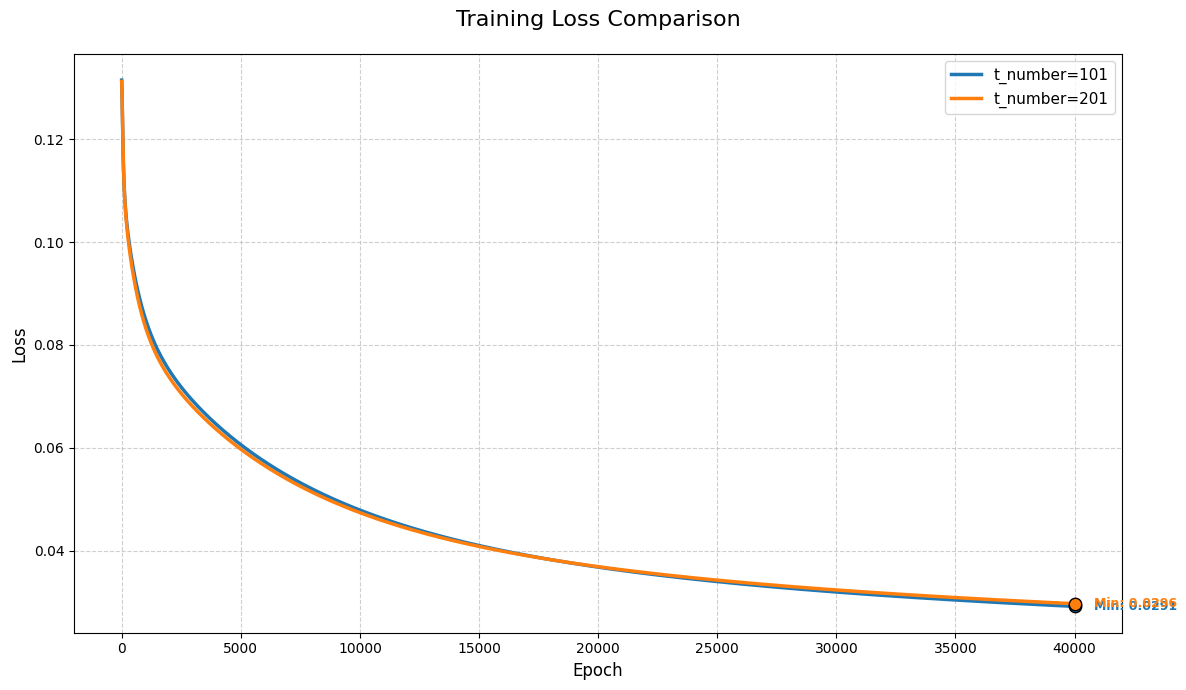

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 1000
x_min, x_max = -2, 7
y_min, y_max = -2, 7

feature_dims = [2048]
t_grids = [101, 201]
loss_histories = []
labels = [f"t_number={p}" for p in t_grids]
fig_all, axes_all = plt.subplots(len(t_grids), 2, figsize=(16, 6 * len(t_grids)))
fig_all.suptitle('Sampling Results Comparison Across Models', fontsize=22, y=0.98)
data_dim = data.shape[1:]

torch.manual_seed(114514) 
z_grid = torch.randn(700, *data_dim, device=device)

for idx, p in enumerate(t_grids):
    print(f"\n=== Training Model {idx+1}/{len(t_grids)} with t_grid_size={p} ===")

    model = RandomFeatureModel(input_dim = input_dim, feature_dim = p, K_t=K_t, T=T).to(device)

    with torch.no_grad(): 
        for param in model.parameters():
            param.zero_()
    
    W_x_np = model.W_x.cpu().numpy()
    W_t_np = model.W_t.cpu().numpy()
    b_np = model.b.cpu().numpy()

    ts = np.linspace(0.0, T, L_t + 1)
    w = np.empty_like(ts)
    if len(ts) >= 2:
        w[1:-1] = (ts[2:] - ts[:-2]) / 2.0
        w[0] = (ts[1] - ts[0]) / 2.0
        w[-1] = (ts[-1] - ts[-2]) / 2.0
    else:
        w[:] = 1.0

    rng = np.random.default_rng(42)
    U_tilde, V_tilde = compute_UV_unweighted(numpy_array, W_x_np, W_t_np, b_np, ts, w, rng)

    A_ref = compute_A_infty(U_tilde, V_tilde)

    loss_history, model = train_simpson(model, data, z_grid, lr=0.05, T = T, device=device, t_grid_size=p)
    loss_histories.append(loss_history)

    # 采样
    samples = sample_exponential(model, num_samples=num_samples, T = T, device=device)
    samples_np = samples.cpu().numpy()
    data_np = data.cpu().numpy()

    print(f"Creating individual and combined visualizations for Model {idx+1}...")

    fig_single, ax_single = plt.subplots(1, 2, figsize=(16, 6))
    fig_single.suptitle(f'Model with t_grid_size={p}', fontsize=18)


    ax_single[0].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.7, color='blue', s=30, label='Generated Samples')
    ax_single[0].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', label='Original Data', zorder=5)
    ax_single[0].set_title('Generated Samples vs. Original Data', fontsize=14)
    ax_single[0].set_xlim(x_min, x_max)
    ax_single[0].set_ylim(y_min, y_max)
    ax_single[0].legend(fontsize=10)
    ax_single[0].grid(True, linestyle='--', alpha=0.6)
    ax_single[0].set_aspect('equal', adjustable='box')

    try:
        sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], cmap="viridis", fill=True, ax=ax_single[1],
                    levels=10, cbar=True, cbar_kws={'label': 'Density'})
        ax_single[1].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', zorder=5) # 加上原始数据点
        ax_single[1].set_title('Generated Samples Density Heatmap', fontsize=14)
    except ValueError as e:
        print(f"⚠️ WARNING (Individual Plot): Could not generate KDE plot for t_grid_size={p}. Error: {e}")
        ax_single[1].text(0.5, 0.5, 'KDE Plot Failed\n(Mode Collapse?)',
                          horizontalalignment='center', verticalalignment='center',
                          transform=ax_single[1].transAxes, fontsize=12, color='red')
        ax_single[1].set_title('Generated Samples Density Heatmap (Failed)', fontsize=14)

    fig_single.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    fig_single.savefig(f"model_t_grid_size_{p}_visualization.png", dpi=150)
    plt.close(fig_single)
    print(f"✅ Saved individual plot: model_t_grid_size_{p}_visualization.png")
    

    # Left: Scatter on combined plot
    axes_all[idx][0].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.7, color='blue', s=30)
    axes_all[idx][0].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', zorder=5)
    axes_all[idx][0].set_title(f'Model {idx+1} (t_grid_size={p}): Scatter', fontsize=14)
    axes_all[idx][0].set_xlim(x_min, x_max)
    axes_all[idx][0].set_ylim(y_min, y_max)
    axes_all[idx][0].grid(True, linestyle='--', alpha=0.6)
    axes_all[idx][0].set_aspect('equal', adjustable='box')
    axes_all[idx][0].set_ylabel('Y-axis', fontsize=12)

    
    try:
        sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], fill=True, thresh=0.0, levels=100, cmap="YlOrBr", ax=axes_all[idx][1])
        sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], fill=False, thresh=0.02, levels=20, cmap="coolwarm", ax=axes_all[idx][1])
        axes_all[idx][1].set_title(f'Model {idx+1} (t_grid_size={p}): Density Heatmap', fontsize=14)
    except ValueError as e:
        print(f"⚠️ WARNING (Combined Plot): Could not generate KDE plot for scaling={p}. Error: {e}")
        axes_all[idx][1].text(0.5, 0.5, 'KDE Plot Failed', horizontalalignment='center', verticalalignment='center',
                              transform=axes_all[idx][1].transAxes, fontsize=12, color='red')
        axes_all[idx][1].set_title(f'Model {idx+1} (t_grid_size={p}): Density Heatmap (Failed)', fontsize=14)
        
    axes_all[idx][1].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', zorder=5)
    axes_all[idx][1].set_xlim(x_min, x_max)
    axes_all[idx][1].set_ylim(y_min, y_max)
    axes_all[idx][1].grid(True, linestyle='--', alpha=0.6)
    axes_all[idx][1].set_aspect('equal', adjustable='box')

    if idx == len(feature_dims) - 1:
        axes_all[idx][0].set_xlabel('X-axis', fontsize=12)
        axes_all[idx][1].set_xlabel('X-axis', fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.96])
fig_all.savefig("sampling_comparison_t_grid_size_2modes_p2048.png", dpi=300, bbox_inches='tight')
print("✅ Saved combined sampling comparison plot: sampling_comparison_t_grid_size_2modes_p2048.png")
plt.close(fig_all)

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(12, 7))

for i, (loss_hist, label) in enumerate(zip(loss_histories, labels)):
    epochs = list(range(1, len(loss_hist) + 1))
    
    # 1. 先画原始 loss，低透明度
    plt.plot(epochs, loss_hist, color=f'C{i}', alpha=0.3, linewidth=1.0, label=None)  # 不加图例

    # 2. 画平滑后的 loss
    smoothed_loss = smooth_curve(loss_hist, factor=0.95)
    plt.plot(epochs, smoothed_loss, label=label, linewidth=2.5, color=f'C{i}')

    # 3. 找到最低 loss 和对应 epoch
    min_loss = min(loss_hist)
    min_epoch = loss_hist.index(min_loss) + 1  # +1 因为 epoch 从 1 开始

    # 4. 标记最低点
    plt.scatter(min_epoch, min_loss, color=f'C{i}', s=80, edgecolors='black', zorder=5)
    
    # 5. 添加文字标注（稍微偏移避免遮挡）
    plt.text(min_epoch + len(loss_hist)*0.02, min_loss, f'Min: {min_loss:.4f}', fontsize=9, color=f'C{i}', va='center', weight='bold')

plt.title("Training Loss Comparison", fontsize=16, pad=20)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("loss_comparison_enhanced_SGD_mean_Sineembedding.png", bbox_inches='tight')
print("✅ Saved enhanced loss comparison plot: loss_comparison_enhanced.png")

print("\n🎉 All done! Models trained, sampled, and all visualizations saved.")

正在生成可视化图像...
快照总数为 401，只显示最后 21 个。


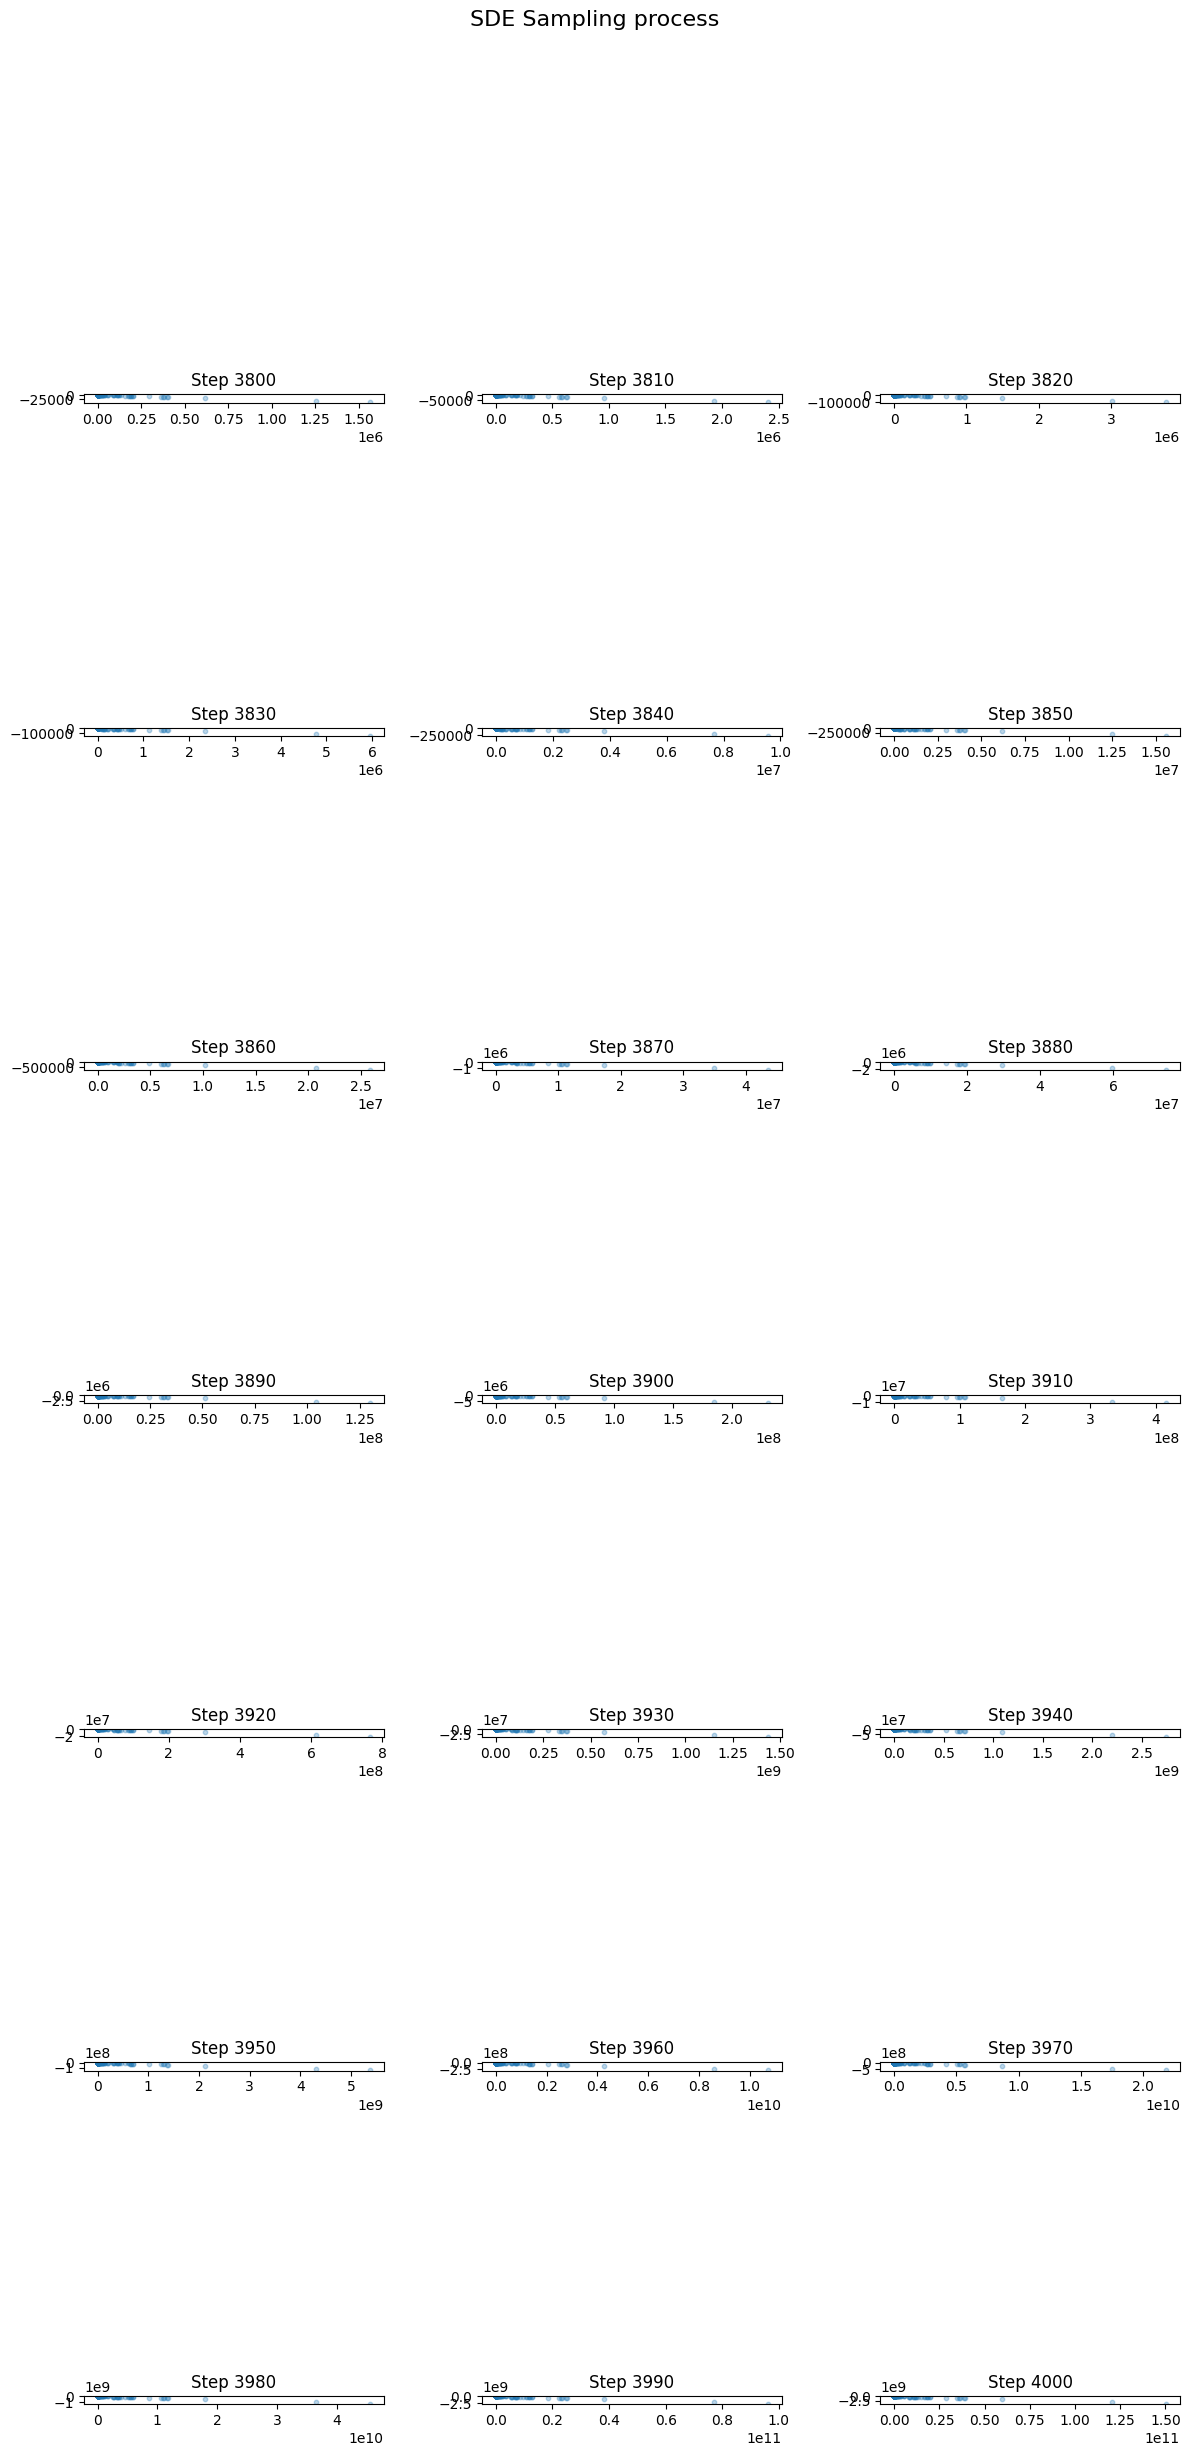

In [6]:
snapshots = sample_exponential(model, num_samples=3000, num_steps=4000, T = T, device=device, num_snapshots = 401)

# --- 3. 可视化快照 (只显示最后10个) ---
if snapshots:
    print("正在生成可视化图像...")
    
    total_num_snapshots = len(snapshots)
    all_snapshot_steps = torch.linspace(0, 4000, 401, dtype=int).tolist()
    
    # --- 核心修改：只获取最后 10 个 ---
    num_to_plot = 21
    if total_num_snapshots > num_to_plot:
        snapshots_to_plot = snapshots[-num_to_plot:]
        steps_to_plot = all_snapshot_steps[-num_to_plot:]
        plot_title = f"SDE Sampling process"
        print(f"快照总数为 {total_num_snapshots}，只显示最后 {num_to_plot} 个。")
    else:
        snapshots_to_plot = snapshots
        steps_to_plot = all_snapshot_steps
        plot_title = f"SDE Sampling process"
        print(f"快照总数 {total_num_snapshots} (小于等于{num_to_plot})，全部显示。")
    # ---------------------------------

    # --- 布局计算（基于要绘制的快照数量）---
    num_snapshots_to_plot = len(snapshots_to_plot) # 使用新的数量
    ncols = 3 # 每行最多3个图
    # 计算需要的行数 (向上取整)
    nrows = (num_snapshots_to_plot + ncols - 1) // ncols 
    
    # 设置图像大小 (宽, 高)
    fig_width = ncols * 4
    fig_height = nrows * 4
    
    # 处理 nrows=0 (即没有快照) 的边缘情况
    if nrows == 0:
        print("没有快照可供显示。")
    else:
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
        
        # 将 axes 数组展平，方便索引
        if num_snapshots_to_plot == 1:
             axes_flat = [axes] # 确保单图时也是可迭代的
        elif nrows == 1:
            axes_flat = axes
        else:
            axes_flat = axes.flatten()
        # ---------------------------------

        # --- 绘图循环（使用切片后的列表）---
        for i, snap in enumerate(snapshots_to_plot):
            data = snap.numpy()
            ax = axes_flat[i] 

            ax.scatter(data[:, 0], data[:, 1], alpha=0.3, s=10)
            # 使用对应的步数
            ax.set_title(f"Step {steps_to_plot[i]}") 
            ax.set_aspect('equal')

        # --- 隐藏多余的子图 ---
        num_total_plots = nrows * ncols
        for i in range(num_snapshots_to_plot, num_total_plots):
            axes_flat[i].axis('off')
        # ------------------------

        plt.suptitle(plot_title, fontsize=16)
        save_filename = "snapshots_visualization.png" 
        plt.savefig(save_filename, dpi=300, bbox_inches='tight')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
        plt.show()

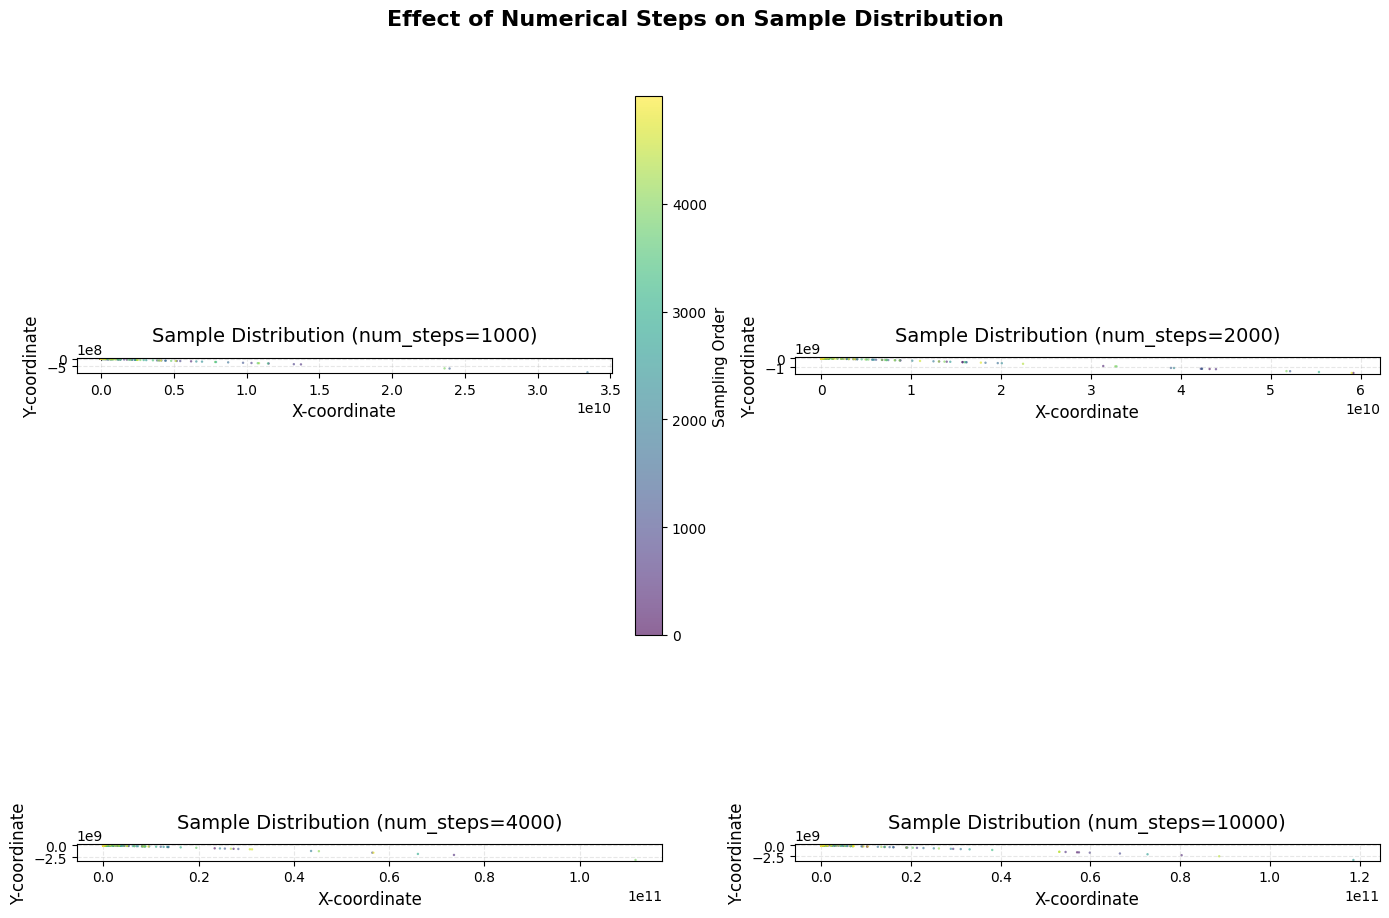

In [7]:
num_steps_list = [1000, 2000, 4000, 10000]
num_samples = 5000 

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  

for idx, num_steps in enumerate(num_steps_list):
    samples = sample_exponential(
        model=model,
        num_samples=num_samples,
        num_steps=num_steps,\
        
        T=T,
        device=device,
        num_snapshots=0
    )
    samples_np = samples.cpu().numpy()  # 转换为NumPy数组
    
    # 绘制散点图
    ax = axes[idx]
    scatter = ax.scatter(
        samples_np[:, 0], 
        samples_np[:, 1],
        s=3,
        alpha=0.6,
        cmap='viridis',
        c=np.arange(num_samples),
        edgecolors='none'
    )
    
    # 设置图表属性
    ax.set_title(
        f'Sample Distribution (num_steps={num_steps})',
        fontsize=14,
        pad=12
    )
    ax.set_xlabel('X-coordinate', fontsize=12)
    ax.set_ylabel('Y-coordinate', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_aspect('equal')
    
    if idx == 0:
        cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Sampling Order', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle(
    'Effect of Numerical Steps on Sample Distribution',
    fontsize=16,
    fontweight='bold'
)
plt.savefig('sample_comparison_steps.png', dpi=300, bbox_inches='tight')
plt.show()

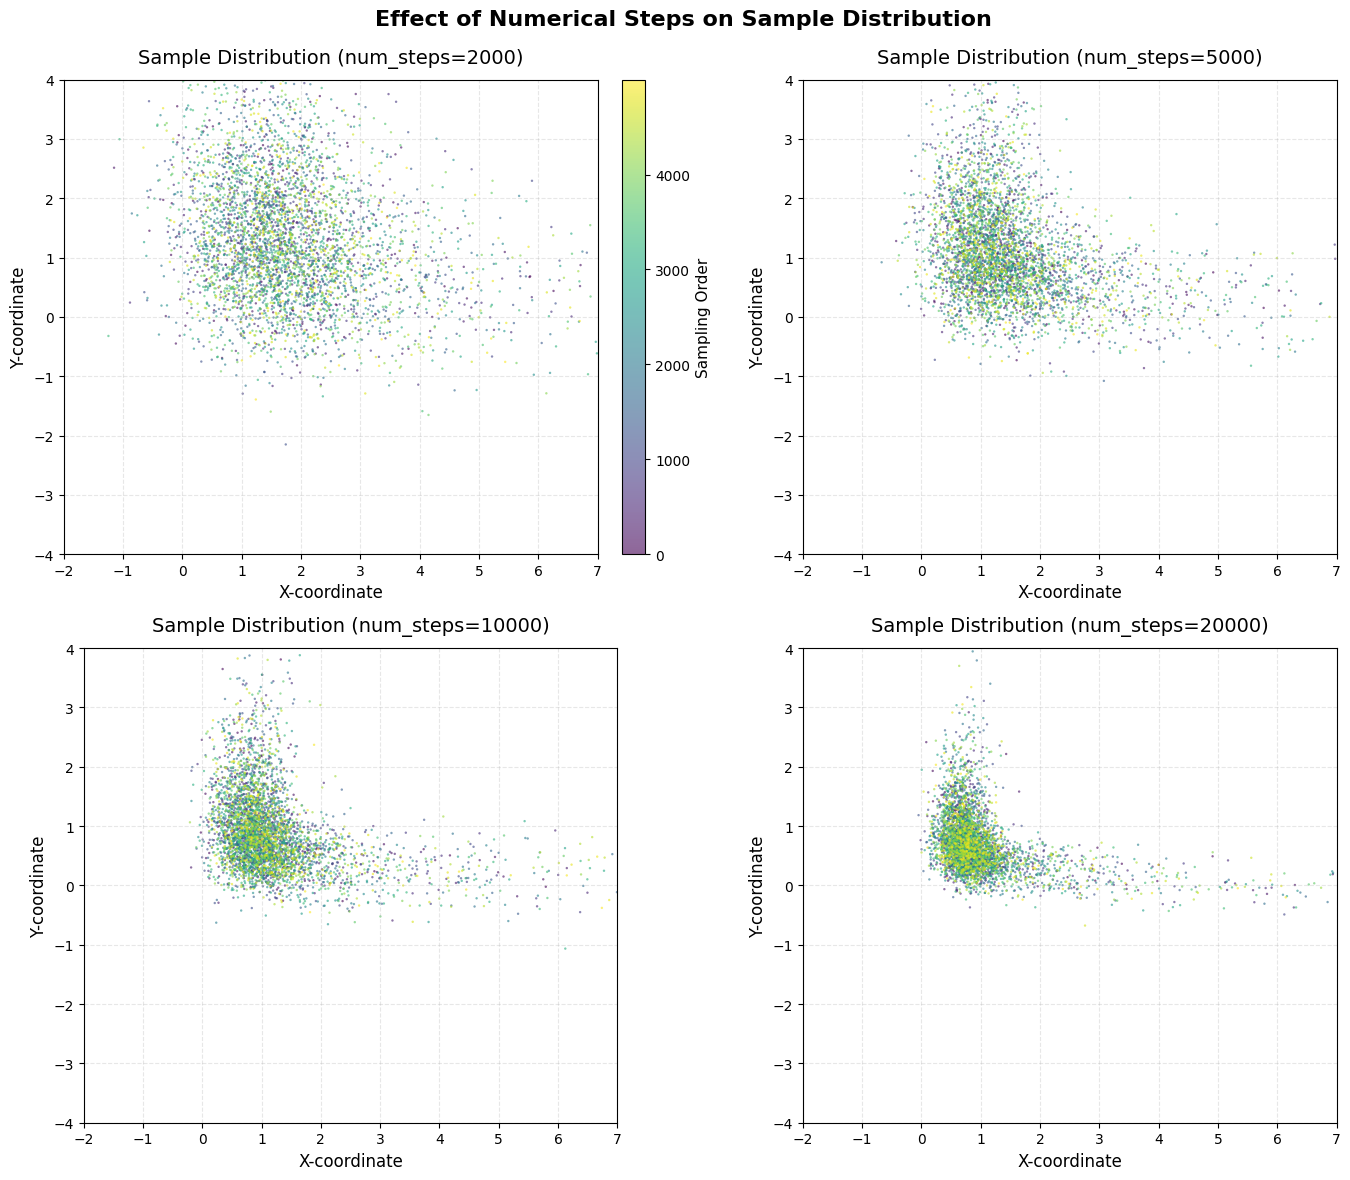

In [8]:
num_steps_list = [2000, 5000, 10000, 20000]
num_samples = 5000 

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  

for idx, num_steps in enumerate(num_steps_list):
    samples = sample_exponential(
        model=model,
        num_samples=num_samples,
        num_steps=num_steps,
        T=T,
        device=device,
        num_snapshots=0
    )
    samples_np = samples.cpu().numpy()  # 转换为NumPy数组
    
    # 绘制散点图
    ax = axes[idx]
    scatter = ax.scatter(
        samples_np[:, 0], 
        samples_np[:, 1],
        s=3,
        alpha=0.6,
        cmap='viridis',
        c=np.arange(num_samples),
        edgecolors='none'
    )
    
    # 设置图表属性
    ax.set_title(
        f'Sample Distribution (num_steps={num_steps})',
        fontsize=14,
        pad=12
    )
    ax.set_xlabel('X-coordinate', fontsize=12)
    ax.set_ylabel('Y-coordinate', fontsize=12)
    ax.set_xlim(-2, 7)
    ax.set_ylim(-4, 4)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_aspect('equal')
    
    if idx == 0:
        cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Sampling Order', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle(
    'Effect of Numerical Steps on Sample Distribution',
    fontsize=16,
    fontweight='bold'
)
plt.savefig('sample_comparison_steps.png', dpi=300, bbox_inches='tight')
plt.show()